In [7]:
from keras.utils.np_utils import to_categorical
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import StratifiedShuffleSplit
import random
from sklearn.model_selection import KFold

In [8]:
seed = 50  
random.seed(seed)

In [9]:
iris = datasets.load_iris()

X = iris['data']  # selecting all features
Y = (iris['target'])  # selecting all labels
Y = to_categorical(Y)  # converting labels to one-hot encoding

#### Stratified Shuffle Split for initial training


In [10]:
sample = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train, test in sample.split(X, Y):
    x_train, x_test, y_train, y_test = X[train], X[test], Y[train], Y[test]

In [11]:
class MultiLayerPerceptron():
    def __init__(self, layer_sizes, epochs=10, learning_rate=0.001, regularization='none', regularization_rate=0.001, activation='sigmoid'):
        """
        Parameters
        ------------
        learning_rate : float
            Learning rate (between 0.0 and 1.0 preferred).
        epochs : int
            number of passes over the training dataset.
        regularization : string
            'l1' , 'l2' or 'none'
        regularization_rate: float
            L1 and L2 regularization parameter
        activation : string
            'sigmoid', 'tanh' or 'relu'
        layer_sizes : list
            list of integers, each integer is the number of nodes in a layer.

        Attributes
        -----------
        weights_ : 1d-array
            Weights after fitting.
        errors_ : list
            Number of misclassifications in every epoch.
        cache_ : dict
            to store network parameters and intermediate results.
        """

        self.layer_sizes = layer_sizes
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.errors_ = []
        self.regularization_rate = regularization_rate
        self.regularization = regularization
        self.activation = activation
        self.cache_ = self.initialization()

    def relu(self, X, derivative=False):
        if derivative:
            return np.where(X > 0, 1, 0)
        return np.maximum(0, X)

    def tanh(self, X, derivative=False):
        if derivative:
            return 1 - np.square(np.tanh(X))
        return np.tanh(X)

    def sigmoid(self, X, derivative=False):
        if derivative:
            return (np.exp(-X)) / ((np.exp(-X) + 1) ** 2)
        return 1 / (1 + np.exp(-X))

    def softmax(self, X, derivative=False):
        # Numerically stable with large exponentials to avoid log(0)
        exps = np.exp(X - X.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        """
        Initialize the weights and number of nodes in layer of the network.
        Returns
        -------
        [params]
            dictionary of weights and number of nodes in layer.
        """
        seed = 50
        np.random.seed(seed)
        # number of nodes in each layer
        input_layer = self.layer_sizes[0]
        hidden_1 = self.layer_sizes[1]
        hidden_2 = self.layer_sizes[2]
        output_layer = self.layer_sizes[3]

        params = {
            'W3': np.random.randn(output_layer, hidden_2),
            'B3': np.zeros(output_layer, ),
            'W2': np.random.randn(hidden_2, hidden_1),
            'B2': np.zeros(hidden_2, ),
            'W1': np.random.randn(hidden_1, input_layer),
            'B1': np.zeros(hidden_1, ),
        }

        return params

    def forward_propagate(self, X):
        """
        This function does a forward pass of x, and returns the output of the network.
        
        returns
        -------
        [params[3]]
            output of the network.
        """
        params = self.cache_
        params['A0'] = X

        # forward propagation to hidden layer 1
        params['Z1'] = np.dot(params["W1"], X) + params['B1']

        # hidden layer 1 activation
        if self.activation == 'relu':
            params['A1'] = self.relu(params['Z1'])
        elif self.activation == 'tanh':
            params['A1'] = self.tanh(params['Z1'])
        else:
            params['A1'] = self.sigmoid(params['Z1'])

        # forward propagation to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1']) + params['B2']

        # hidden layer 2 activation
        if self.activation == 'relu':
            params['A2'] = self.relu(params['Z2'])
        elif self.activation == 'tanh':
            params['A2'] = self.tanh(params['Z2'])
        else:
            params['A2'] = self.sigmoid(params['Z2'])

        # forward propagation to output layer
        params['Z3'] = np.dot(params["W3"], params['A2']) + params['B3']
        # output layer activation
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']  # return the output of the network

    def back_propagate(self, Y, output):
        '''
        This is the backpropagation algorithm, for calculating the gradients or derivatives
        of the neural network's parameters.

        returns
        -------
        [grads]
            dictionary of gradients of the network's parameters.
        '''
        params = self.cache_
        grads = {}
        m = len(Y)

        ## =========================== Regularization L2 =========================== ##

        if self.regularization == 'l2':

            error = 2 * (output - Y) / output.shape[0] * self.softmax(params['Z3'], derivative=True)

            grads['W3'] = np.outer(error, params['A2']) + (self.regularization_rate * self.cache_['W3']) / m
            grads['B3'] = np.sum(error, axis=0)

            # Calculate W2 update
            if self.activation == 'relu':
                error = np.dot(params['W3'].T, error) * self.relu(params['Z2'], derivative=True)
            elif self.activation == 'tanh':
                error = np.dot(params['W3'].T, error) * self.tanh(params['Z2'], derivative=True)
            else:
                error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
            grads['W2'] = np.outer(error, params['A1']) + (self.regularization_rate * self.cache_['W2']) / m
            grads['B2'] = np.sum(error, axis=0)

            # Calculate W1 update
            if self.activation == 'relu':
                error = np.dot(params['W2'].T, error) * self.relu(params['Z1'], derivative=True)
            elif self.activation == 'tanh':
                error = np.dot(params['W2'].T, error) * self.tanh(params['Z1'], derivative=True)
            else:
                error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
            grads['W1'] = np.outer(error, params['A0']) + (self.regularization_rate * self.cache_['W1']) / m
            grads['B1'] = np.sum(error, axis=0)

            return grads

        ## =========================== Regularization L1 =========================== ##

        elif self.regularization == 'l1':
            error = 2 * (output - Y) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
            grads['W3'] = np.outer(error, params['A2']) + (self.regularization_rate * np.sign(self.cache_['W3']))
            grads['B3'] = np.sum(error, axis=0)

            # Calculate W2 update
            if self.activation == 'relu':
                error = np.dot(params['W3'].T, error) * self.relu(params['Z2'], derivative=True)
            elif self.activation == 'tanh':
                error = np.dot(params['W3'].T, error) * self.tanh(params['Z2'], derivative=True)
            else:
                error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
            grads['W2'] = np.outer(error, params['A1']) + (self.regularization_rate * np.sign(self.cache_['W2']))
            grads['B2'] = np.sum(error, axis=0)

            # Calculate W1 update
            if self.activation == 'relu':
                error = np.dot(params['W2'].T, error) * self.relu(params['Z1'], derivative=True)
            elif self.activation == 'tanh':
                error = np.dot(params['W2'].T, error) * self.tanh(params['Z1'], derivative=True)
            else:
                error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
            grads['W1'] = np.outer(error, params['A0']) + (self.regularization_rate * np.sign(self.cache_['W1']))
            grads['B1'] = np.sum(error, axis=0)

            return grads


        ## =========================== No Regularization =========================== ##

        else:
            error = 2 * (output - Y) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
            grads['W3'] = np.outer(error, params['A2'])
            grads['B3'] = np.sum(error, axis=0)

            # Calculate W2 update
            if self.activation == 'relu':
                error = np.dot(params['W3'].T, error) * self.relu(params['Z2'], derivative=True)
            elif self.activation == 'tanh':
                error = np.dot(params['W3'].T, error) * self.tanh(params['Z2'], derivative=True)
            else:
                error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
            grads['W2'] = np.outer(error, params['A1'])
            grads['B2'] = np.sum(error, axis=0)

            # Calculate W1 update
            if self.activation == 'relu':
                error = np.dot(params['W2'].T, error) * self.relu(params['Z1'], derivative=True)
            elif self.activation == 'tanh':
                error = np.dot(params['W2'].T, error) * self.tanh(params['Z1'], derivative=True)
            else:
                error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
            grads['W1'] = np.outer(error, params['A0'])
            grads['B1'] = np.sum(error, axis=0)

        return grads

    def cross_entropy(self, output, Y):
        """ 
        This function calculates the cross entropy loss of the network.

        returns
        -------
        [loss]
            the cross entropy loss of the network.
        """
        params = self.cache_
        m = len(Y)

        if self.regularization == 'l1':
            reg_loss = (np.sum(np.abs(params['W1'])) + np.sum(np.abs(params['W2'])) + np.sum(np.abs(params['W3']))) * self.regularization_rate
            loss = -np.sum(Y * np.log(output))
            loss = loss + reg_loss

        elif self.regularization == 'l2':
            reg_loss = (np.sum(np.square(params['W1'])) + np.sum(np.square(params['W2'])) + np.sum(np.square(params['W3']))) * self.regularization_rate/2
            loss = -np.sum(Y * np.log(output))
            loss = loss + reg_loss
        else:

            loss = -np.sum(Y * np.log(output))

        return loss

    def gradient_descent(self, grads):
        '''
        This function updates the network's parameters using gradient descent.
        '''

        for key, value in grads.items():
            self.cache_[key] -= self.learning_rate * value

    def calculate_accuracy(self, X, Y):
        '''
        This function calculates the accuracy of the network on the given data.
        (Note: this is not the same as cross entropy loss)
        '''
        y_pred = []

        for x, y in zip(X, Y):
            output = self.forward_propagate(x)
            pred = np.argmax(output)
            y_pred.append(pred == np.argmax(y))

        return np.mean(y_pred)

    def fit(self, X, Y):
        """
        This function trains the network on the given data.
        """
        start_time = time.time()
        for epoch in range(self.epochs):
            for x, y in zip(X, Y):
                output = self.forward_propagate(x)
                grads = self.back_propagate(y, output)
                self.gradient_descent(grads)

            error = self.cross_entropy(output, y)
            self.errors_.append(error)
            accuracy = self.calculate_accuracy(X, Y)
            print(
                f'Epoch: {epoch + 1} [==========================] Time: {time.time() - start_time:.2}s | Error: {error:.2f} | Acc: {accuracy * 100:.2f}%')

    def evaluate(self, X, Y):
        """
        This function evaluates the network on the given data.
        (Note: evaluation is done with both cross entropy loss and accuracy)
        """

        for x, y in zip(X, Y):
            output = self.forward_propagate(x)
            loss = self.cross_entropy(output, y)
            accuracy = self.calculate_accuracy(X, Y)

        return print(f'Cross Entropy Testing Error: {loss:.2f} and Accuracy: {accuracy * 100:.2f}%')

    def validation(self, X, Y, k):
        """
        This function does k-fold validation on the given data.
        """
        kf = KFold(n_splits=k)
        kf.get_n_splits(X)

        for fold, (train_index, test_index) in enumerate(kf.split(X)):
            print('===================')
            print(f'Fold: {fold}')
            print('===================\n')

            X_train, X_test = X[train_index], X[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]

            self.fit(X_train, Y_train)
            self.evaluate(X_test, Y_test)

    def print_weights(self, prompt):
        """
        This function prints the weights of the network.
        """
        W1 = self.cache_['W1']
        W2 = self.cache_['W2']
        W3 = self.cache_['W3']

        print('[=========================================================]')
        print(f'Weight W1 {prompt}: \n{W1}')
        print('[=========================================================]')
        print(f'Weight W2 {prompt}: \n{W2}')
        print('[=========================================================]')
        print(f'Weight W3 {prompt}: \n{W3}')


```
HyperParameters:
    layer_sizes: list of integers, each integer is the size of a layer.
    epochs: integer, number of epochs to train the network.
    learning_rate: float, learning rate for the network.
    regularization: string, either 'l1' or 'l2' or 'none'.
    regularization_rate: float, the regularization rate.
    activation: string, either 'sigmoid' or 'relu' or 'tanh' for hidden layers only.
```


In [39]:
clf = MultiLayerPerceptron(layer_sizes=[4, 3, 3, 3], epochs=100, learning_rate=0.01, activation='relu')

In [40]:
clf.fit(x_train, y_train)

Epoch: 1 [==========================] Time: 0.031s | Error: 1.36 | Acc: 66.67%
Epoch: 2 [==========================] Time: 0.054s | Error: 1.29 | Acc: 66.67%
Epoch: 3 [==========================] Time: 0.076s | Error: 1.24 | Acc: 66.67%
Epoch: 4 [==========================] Time: 0.097s | Error: 1.23 | Acc: 67.50%
Epoch: 5 [==========================] Time: 0.12s | Error: 1.21 | Acc: 69.17%
Epoch: 6 [==========================] Time: 0.13s | Error: 1.21 | Acc: 69.17%
Epoch: 7 [==========================] Time: 0.15s | Error: 1.20 | Acc: 70.83%
Epoch: 8 [==========================] Time: 0.17s | Error: 1.16 | Acc: 70.00%
Epoch: 9 [==========================] Time: 0.19s | Error: 1.15 | Acc: 74.17%
Epoch: 10 [==========================] Time: 0.21s | Error: 1.13 | Acc: 75.00%
Epoch: 11 [==========================] Time: 0.23s | Error: 1.11 | Acc: 79.17%
Epoch: 12 [==========================] Time: 0.25s | Error: 1.09 | Acc: 81.67%
Epoch: 13 [==========================] Time: 0.28s | Erro

In [36]:
clf.evaluate(x_test, y_test)

Cross Entropy Testing Error: 0.24 and Accuracy: 100.00%


In [37]:
clf.validation(x_train, y_train, k=5)

Fold: 0

Epoch: 1 [==========================] Time: 0.025s | Error: 0.79 | Acc: 95.83%
Epoch: 2 [==========================] Time: 0.048s | Error: 0.78 | Acc: 95.83%
Epoch: 3 [==========================] Time: 0.072s | Error: 0.77 | Acc: 95.83%
Epoch: 4 [==========================] Time: 0.1s | Error: 0.77 | Acc: 95.83%
Epoch: 5 [==========================] Time: 0.13s | Error: 0.76 | Acc: 95.83%
Epoch: 6 [==========================] Time: 0.14s | Error: 0.76 | Acc: 95.83%
Epoch: 7 [==========================] Time: 0.16s | Error: 0.75 | Acc: 95.83%
Epoch: 8 [==========================] Time: 0.18s | Error: 0.74 | Acc: 95.83%
Epoch: 9 [==========================] Time: 0.19s | Error: 0.74 | Acc: 96.88%
Epoch: 10 [==========================] Time: 0.21s | Error: 0.73 | Acc: 96.88%
Epoch: 11 [==========================] Time: 0.23s | Error: 0.73 | Acc: 96.88%
Epoch: 12 [==========================] Time: 0.24s | Error: 0.72 | Acc: 96.88%
Epoch: 13 [==========================] Time: 0.26s

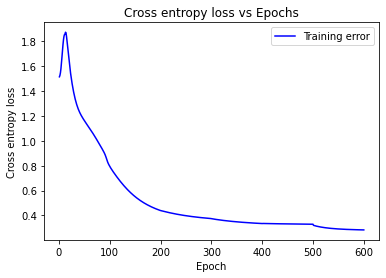

In [38]:
plt.plot(range(1, len(clf.errors_) + 1), clf.errors_, 'b', label='Training error')
plt.title('Cross entropy loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross entropy loss')
# plt.ylim(ymin=0)
plt.legend()
plt.show()